In [1]:
import random

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.torch as fotorch
import fiftyone.utils.annotations as foua
import fiftyone.utils.patches as foup

import torch
import torchvision.datasets as dset
import torch.optim as optim
import torch.nn as nn
import torchvision as tv
from torchvision import transforms as tf
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import functional as tfunc
from torch.utils.data import DataLoader
import torchvision.utils as vutils

import torchviz

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
from sklearn.cluster import KMeans, OPTICS, DBSCAN, Birch

In [2]:
# Run the model on GPU if it is available
ngpu = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# coco_17_train = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     dataset_name="detector-recipe",
#     label_types=["detections", "segmentations"]
# )

# coco_17_test = foz.load_zoo_dataset(
#     "coco-2017",
#     split="test",
#     dataset_name="detector-recipe",
#     label_types=["detections", "segmentations"]
# )

# coco_17_validation = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     dataset_name="detector-recipe",
#     label_types=["segmentations"]
# )

In [4]:
def draw_image(image):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    if len(image.shape) == 2:
        plt.imshow(image, cmap="binary", interpolation="none")
    else:
        plt.imshow(image, interpolation="none")
    plt.show()
    plt.close()

In [5]:
train_dataset = dset.CocoDetection(
    root='/home/boggsj/fiftyone/coco-2017/train/data',
    annFile='/home/boggsj/fiftyone/coco-2017/raw/instances_train2017.json',
    transform=tf.Compose([
#         tf.Resize((448,448)),
        tf.ToTensor()
    ])
)
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=15.79s)
creating index...
index created!


torch.Size([1, 3, 640, 427])


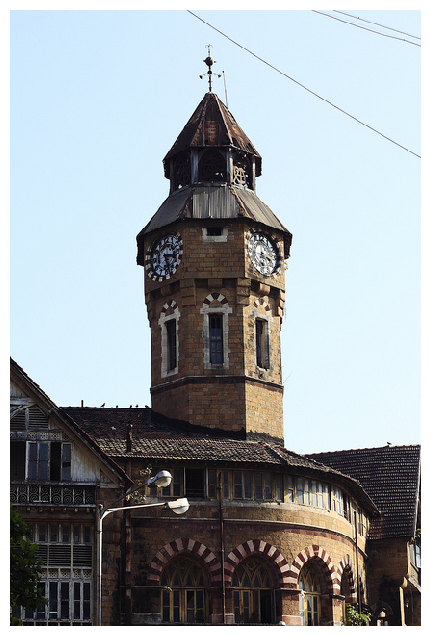

In [6]:
test_input = next(iter(train_data_loader))
test_tens = test_input[0].to(device)
print(test_tens.shape)

draw_image(test_tens.detach().cpu().squeeze().transpose(0,2).transpose(0,1))

In [7]:
resnet50_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50_backbone.to(device)
resnet50_backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
class FPNStage(nn.Module):
    def __init__(self, fpn_dim, bbone_dim):
        super().__init__()
        self.lat = nn.Conv2d(bbone_dim, fpn_dim, kernel_size=1)
        self.top = nn.ConvTranspose2d(fpn_dim, fpn_dim, kernel_size=4, stride=2, padding=1)
        self.aa  = nn.Conv2d(fpn_dim, fpn_dim, kernel_size=3, stride=1, padding=1)
        
    def forward(self, bbone_activation, prev_fpn_stage):
        lat_out = self.lat(bbone_activation)
        top_out = self.top(prev_fpn_stage)
        
        if not lat_out.shape == top_out.shape:
            top_out = nn.UpsamplingNearest2d(size=lat_out.shape[2:])(top_out)          
            
        final_out = self.aa(lat_out + top_out)
        return final_out
        

class FeatureExtractor(nn.Module):
    def __init__(self, ngpu=1, fpn_dim=256):
        super().__init__()
        self.ngpu = ngpu
        self.num_fpn_stages = 4
        self.fpn_dim = fpn_dim
        
        self.activation = {}
        self.resnet50_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50_backbone.layer1.register_forward_hook(self.get_activation('conv2'))
        self.resnet50_backbone.layer2.register_forward_hook(self.get_activation('conv3'))
        self.resnet50_backbone.layer3.register_forward_hook(self.get_activation('conv4'))
        self.resnet50_backbone.layer4.register_forward_hook(self.get_activation('conv5'))
        
        self.fpn_stage_1 = nn.Conv2d(2048, self.fpn_dim, kernel_size=1)
        self.fpn_stage_2 = FPNStage(self.fpn_dim, 1024)
        self.fpn_stage_3 = FPNStage(self.fpn_dim, 512)
        self.fpn_stage_4 = FPNStage(self.fpn_dim, 256)
        
    def forward(self, input):
        backbone_output = self.resnet50_backbone(input)
        fpn_stage_1_output = self.fpn_stage_1(self.activation['conv5'])
        fpn_stage_2_output = self.fpn_stage_2(self.activation['conv4'], fpn_stage_1_output)
        fpn_stage_3_output = self.fpn_stage_3(self.activation['conv3'], fpn_stage_2_output)
        fpn_stage_4_output = self.fpn_stage_4(self.activation['conv2'], fpn_stage_3_output)

        
        return fpn_stage_4_output
        
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook 

In [9]:
class Projector(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(fpn_dim, fpn_dim, 1),
            nn.ReLU(inplace=False),
            nn.Linear(fpn_dim, fpn_dim, 1),
            nn.ReLU(inplace=False)
        )
        
    def forward(self, input):
        return self.main(input)

In [10]:
class Predictor(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(fpn_dim, fpn_dim, 1),
            nn.ReLU(inplace=False),
            nn.Linear(fpn_dim, fpn_dim, 1),
            nn.ReLU(inplace=False)
        )
        
    def forward(self, input):
        return self.main(input)

In [11]:
class TauModel(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.f = FeatureExtractor(fpn_dim=fpn_dim)
        self.g = Projector(fpn_dim=fpn_dim)
        
    def forward(self, input):
        h = self.f(input)
        z = self.g(h.transpose(1,3)).transpose(3,1)
        return h, z
        
class ThetaXiModel(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.f = FeatureExtractor(fpn_dim=fpn_dim)
        self.g = Projector(fpn_dim=fpn_dim)
        self.q = Predictor(fpn_dim=fpn_dim)
        
    def forward(self, input):
        h = tfunc.resize(self.f(input), (224, 224), tf.InterpolationMode.BILINEAR)
        z = self.g(h)
        p = self.q(z)
        return h, z, p
    

In [12]:
model_tau = TauModel(64).to(device)
model_theta = ThetaXiModel(64).to(device)
model_xi = ThetaXiModel(64).to(device)

In [13]:
class ViewGenerator(nn.Module):
    """
    nn.Module sub-class which, when called on an image, generates three views of the image, v0, v1, and v2. v1
    and v2 are generated first, and then v0 is generated from their bounding box. The class also has a
    `reverse` method which, given an image the size of v0, produces the equivalent v1 and v2 crops from it.
    """
    SCALE_RANGE = (0.08, 1.0)
    RATIO_RANGE = (0.75, 1.33333333333)

    FLIP_PROB = 0.5

    COLOR_JITTER_PROB = 0.8
    COLOR_OPERATIONS = ["brightness", "contrast", "saturation", "hue"]
    BRIGHTNESS_MAX = 0.4
    CONTRAST_MAX = 0.4
    SATURATION_MAX = 0.2
    HUE_MAX = 0.1

    GRAY_PROB = 0.2

    v1_BLUR_PROB = 1.0
    v2_BLUR_PROB = 0.1

    v1_SOLAR_PROB = 0.0
    v2_SOLAR_PROB = 0.2

    v0_SHAPE = (448, 448)
    v1_SHAPE = v2_SHAPE = (224, 224)
    INTERPOLATION = tf.InterpolationMode.BILINEAR

    def __init__(self, image):
        super().__init__()
        self.crop_v1= tf.RandomResizedCrop.get_params(image, self.SCALE_RANGE, self.RATIO_RANGE)
        self.crop_v2 = tf.RandomResizedCrop.get_params(image, self.SCALE_RANGE, self.RATIO_RANGE)
        
        flip_v1 = random.random() < self.FLIP_PROB
        flip_v2 = random.random() < self.FLIP_PROB
        
        gray_v1 = random.random() < self.GRAY_PROB
        gray_v2 = random.random() < self.GRAY_PROB
        
        blur_v1 = random.random() < self.v1_BLUR_PROB
        blur_v2 = random.random() < self.v2_BLUR_PROB
        
        solar_v1 = random.random() < self.v1_SOLAR_PROB
        solar_v2 = random.random() < self.v2_SOLAR_PROB
        
        if random.random() < self.COLOR_JITTER_PROB: 
            color_params = tf.ColorJitter.get_params(
                [max(0, 1 - self.BRIGHTNESS_MAX), 1 + self.BRIGHTNESS_MAX],
                [max(0, 1 - self.CONTRAST_MAX), 1 + self.CONTRAST_MAX],
                [max(0, 1 - self.SATURATION_MAX), 1 + self.SATURATION_MAX],
                [-self.HUE_MAX, self.HUE_MAX]
            )
            order = color_params[0]
            color_params = color_params[1:]
            jitter_v1 = [(self.COLOR_OPERATIONS[i], color_params[i]) for i in order]
        else:
            jitter_v1 = None
        if random.random() < self.COLOR_JITTER_PROB: 
            color_params = tf.ColorJitter.get_params(
                [max(0, 1 - self.BRIGHTNESS_MAX), 1 + self.BRIGHTNESS_MAX],
                [max(0, 1 - self.CONTRAST_MAX), 1 + self.CONTRAST_MAX],
                [max(0, 1 - self.SATURATION_MAX), 1 + self.SATURATION_MAX],
                [-self.HUE_MAX, self.HUE_MAX]
            )
            order = color_params[0]
            color_params = color_params[1:]
            jitter_v2 = [(self.COLOR_OPERATIONS[i], color_params[i]) for i in order]
        else:
            jitter_v2 = None
        
        self.v1_params = (self.crop_v1, flip_v1, jitter_v1, gray_v1, blur_v1, solar_v1, self.v1_SHAPE)
        self.v2_params = (self.crop_v2, flip_v2, jitter_v2, gray_v2, blur_v2, solar_v2, self.v2_SHAPE)
        
        self.v1_proportional_crop = None
        self.v2_proportional_crop = None
        
    def __call__(self, img):
        v1 = self._generate_sub_view(img, self.v1_params)
        v2 = self._generate_sub_view(img, self.v2_params)
        v0 = self._generate_whole_view(img, self.crop_v1, self.crop_v2)
        
        return v0, v1, v2
    
    def reverse(self, image):
        image_height, image_width = image.shape[-2:]
        
        v1_top_scaled = round(self.v1_proportional_crop[0] * image_height)
        v1_left_scaled = round(self.v1_proportional_crop[1] * image_width)
        v1_height_scaled = round(self.v1_proportional_crop[2] * image_height)
        v1_width_scaled = round(self.v1_proportional_crop[3] * image_width)
        
        v2_top_scaled = round(self.v2_proportional_crop[0] * image_height)
        v2_left_scaled = round(self.v2_proportional_crop[1] * image_width)
        v2_height_scaled = round(self.v2_proportional_crop[2] * image_height)
        v2_width_scaled = round(self.v2_proportional_crop[3] * image_width)
        
        v1_scaled = tfunc.resized_crop(image, v1_top_scaled, v1_left_scaled, v1_height_scaled, v1_width_scaled, self.v1_SHAPE, tf.InterpolationMode.BILINEAR)
        v2_scaled = tfunc.resized_crop(image, v2_top_scaled, v2_left_scaled, v2_height_scaled, v2_width_scaled, self.v2_SHAPE, tf.InterpolationMode.BILINEAR)
        
        if self.v1_params[1]: v1_scaled = tfunc.hflip(v1_scaled)
        if self.v2_params[1]: v2_scaled = tfunc.hflip(v2_scaled)
        
        return v1_scaled, v2_scaled
        
    def _generate_whole_view(self, image, crop_v1, crop_v2):
        v1_top, v1_left, v1_height, v1_width = crop_v1
        v2_top, v2_left, v2_height, v2_width = crop_v2
        v1_bot = v1_top + v1_height
        v1_right = v1_left + v1_width
        v2_bot = v2_top + v2_height
        v2_right = v2_left + v2_width
        
        v0_top = min(v1_top, v2_top)
        v0_left = min(v1_left, v2_left)
        v0_bot = max(v1_bot, v2_bot)    
        v0_right = max(v1_right, v2_right)
        v0_height = v0_bot - v0_top
        v0_width = v0_right - v0_left
        
        self.v0_crop = (v0_top, v0_left, v0_height, v0_width)
        
        v1_proportional_top = (v1_top - v0_top)/v0_height
        v1_proportional_left = (v1_left - v0_left)/v0_width
        v1_proportional_height = v1_height/v0_height
        v1_proportional_width = v1_width/v0_width
        self.v1_proportional_crop = (v1_proportional_top, v1_proportional_left, v1_proportional_height, v1_proportional_width)
        
        v2_proportional_top = (v2_top - v0_top)/v0_height
        v2_proportional_left = (v2_left - v0_left)/v0_width
        v2_proportional_height = v2_height/v0_height
        v2_proportional_width = v2_width/v0_width
        self.v2_proportional_crop = (v2_proportional_top, v2_proportional_left, v2_proportional_height, v2_proportional_width)
        
        return tfunc.resized_crop(image, v0_top, v0_left, v0_height, v0_width, self.v0_SHAPE, tf.InterpolationMode.BILINEAR)
    
    def _generate_sub_view(self, image, params):
        crop, flip, jitter, gray, blur, solar, shape = params
        
        t, l, h, w = crop
        output = tfunc.resized_crop(image, t, l, h, w, shape, self.INTERPOLATION)
        if flip: output = tfunc.hflip(output)
        if jitter is not None:
            for param, value in jitter:
                if param == "brightness": output = tfunc.adjust_brightness(output, value)
                elif param == "contrast": output = tfunc.adjust_contrast(output, value)
                elif param == "hue": output = tfunc.adjust_hue(output, value)
                elif param == "saturation": output = tfunc.adjust_saturation(output, value)
        if gray: output = tfunc.rgb_to_grayscale(output, 3)
        if blur: output = tfunc.gaussian_blur(output, 23, (0.1, 2.0))
        if solar: output = tfunc.solarize(output, 0.5)

        return output

v0 (torch.Size([1, 3, 448, 448])):


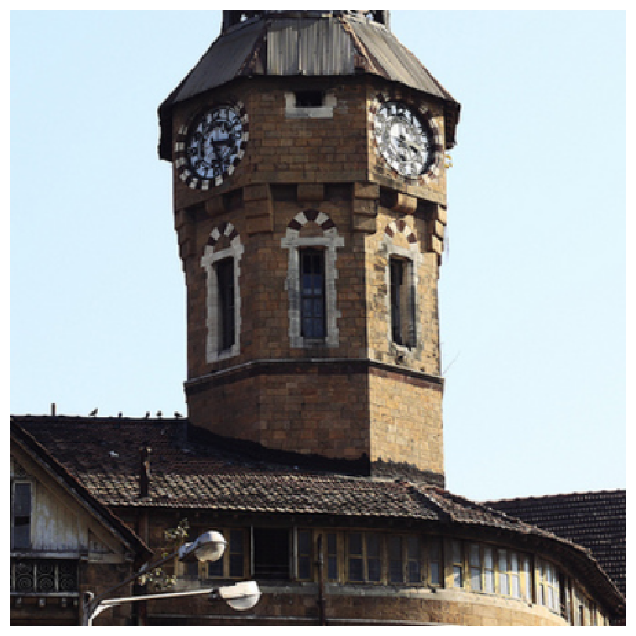

v1 (torch.Size([1, 3, 224, 224])):


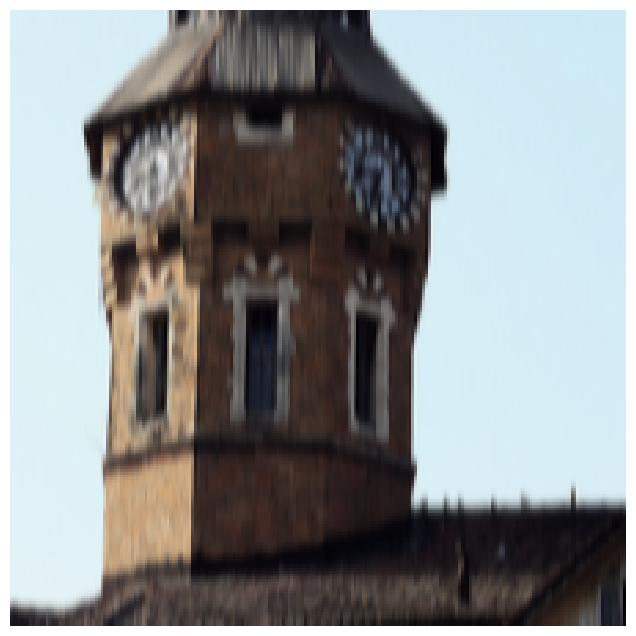

v2 (torch.Size([1, 3, 224, 224])):


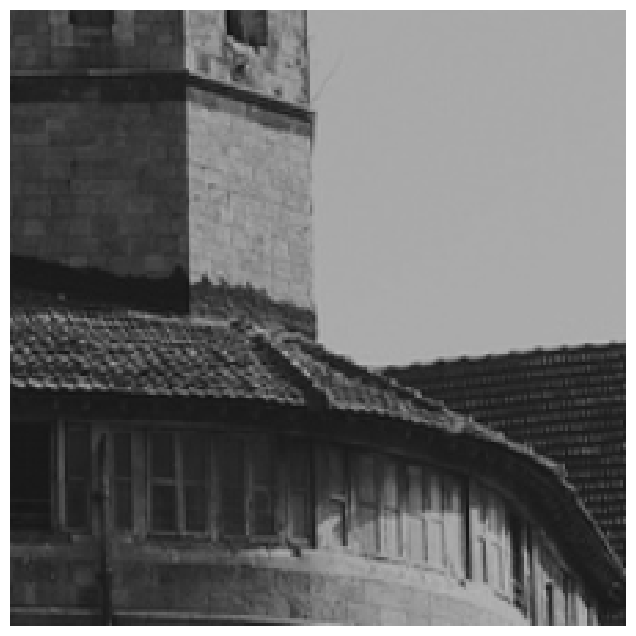

In [14]:
view_gen = ViewGenerator(test_tens)

v0, v1, v2 = view_gen(test_tens)

print(f"v0 ({v0.shape}):")
draw_image(v0.squeeze().detach().cpu().numpy().transpose(1,2,0))
print(f"v1 ({v1.shape}):")
draw_image(v1.squeeze().detach().cpu().numpy().transpose(1,2,0))
print(f"v2 ({v2.shape}):")
draw_image(v2.squeeze().detach().cpu().numpy().transpose(1,2,0))

torch.Size([1, 64, 112, 112])
(64, 112, 112)


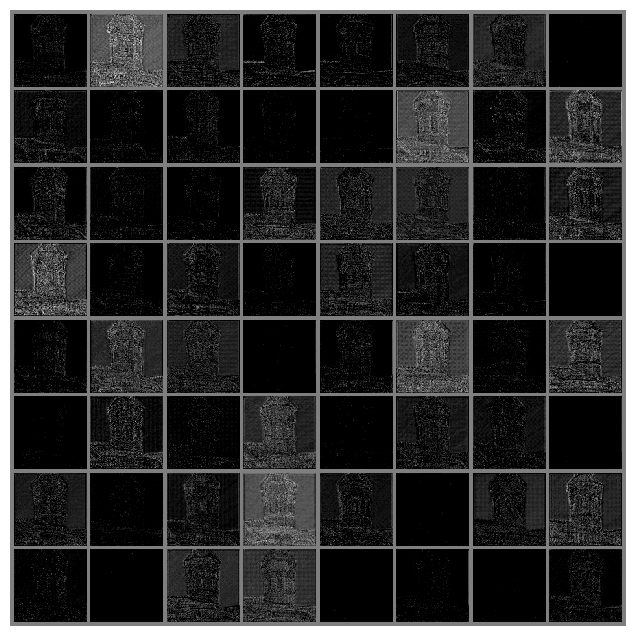

In [15]:
h0, z0 = model_tau(v0)
print(z0.shape)

z0_np = z0.detach().cpu().numpy().squeeze()
print(z0_np.shape)
draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in z0_np], nrow=int(len(z0_np)**0.5), padding=6, pad_value=0.5, normalize=True).cpu(), (1,2,0)))

In [16]:
def generate_masks(z0, clusterer):
    z0_np = np.transpose(z0.detach().cpu().squeeze(),(1,2,0))
    
    original_shape = z0_np.shape
    flat_shape = (original_shape[0]*original_shape[1], original_shape[2])
    z0_np_flat = z0_np.reshape((flat_shape))
#     print(z0_np_flat.shape)
    
    mask_assignments_flat = clusterer.fit_predict(z0_np_flat)
    cluster_ids = set(mask_assignments_flat)
    num_masks = len(cluster_ids)
    
    mask_assignments = tfunc.to_tensor(mask_assignments_flat.reshape(original_shape[:2])).squeeze()
    m0_layers = [torch.where(mask_assignments==c_id, 1.0, 0.).numpy() for c_id in sorted(cluster_ids)]
    m0_np = np.stack(m0_layers, 2)
    m0 = tfunc.to_tensor(m0_np).to(device)
    
    m1_raw, m2_raw = view_gen.reverse(m0)
    m1 = m1_raw[torch.argwhere(m1_raw.sum(dim=(1,2))>0)].squeeze()
    m2 = m2_raw[torch.argwhere(m2_raw.sum(dim=(1,2))>0)].squeeze()
    
    return num_masks, m0, m1, m2

11
(11, 112, 112)


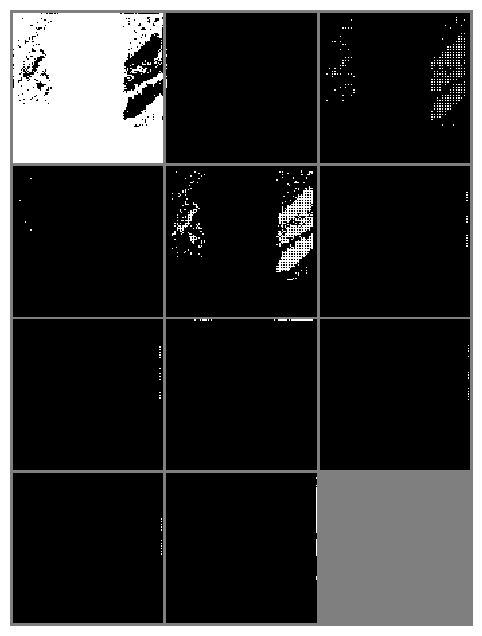

In [17]:
# clusterer = KMeans(n_clusters=16, init='k-means++', n_init=10, max_iter=300, tol=0.00001, verbose=0, random_state=None, copy_x=False, algorithm='elkan')
clusterer = OPTICS(cluster_method="dbscan", eps=0.186-(0.14*0.75), n_jobs=4)
# clusterer = DBSCAN(n_jobs=4)
# clusterer = Birch(n_clusters=None)
num_masks, m0, m1, m2 = generate_masks(z0, clusterer)

print(num_masks)
m0_np = m0.detach().cpu().numpy().squeeze()
print(m0_np.shape)
if num_masks > 1:
    draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in m0_np], nrow=int(num_masks**0.5), padding=2, pad_value=0.5, normalize=True).cpu(), (1,2,0)))
else:
    draw_image(m0_np)

In [18]:
dists = torch.cdist(z0, z0, p=2)
print(f"Min: {dists.min().item()}\nMean: {dists.mean().item()}\nStdDev: {dists.std().item()}\nMax: {dists.max().item()}")
set(clusterer.labels_)

Min: 0.0
Mean: 0.6974797248840332
StdDev: 0.4666258990764618
Max: 3.468956708908081


{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [19]:
lambda_tau = 0.05
lambda_theta = 0.05
lambda_xi = 0.05

In [20]:
f_theta_optimizer = optim.SGD(model_theta.f.parameters(), lr=lambda_theta)
g_theta_optimizer = optim.SGD(model_theta.g.parameters(), lr=lambda_theta)
q_theta_optimizer = optim.SGD(model_theta.q.parameters(), lr=lambda_theta)

f_theta_optimizer.zero_grad()
g_theta_optimizer.zero_grad()
q_theta_optimizer.zero_grad()

In [21]:
f_xi_optimizer = optim.SGD(model_xi.f.parameters(), lr=lambda_xi)
g_xi_optimizer = optim.SGD(model_xi.g.parameters(), lr=lambda_xi)
q_xi_optimizer = optim.SGD(model_xi.q.parameters(), lr=lambda_xi)

f_xi_optimizer.zero_grad()
g_xi_optimizer.zero_grad()
q_xi_optimizer.zero_grad()

In [22]:
def single_mask_similarity(pk1_theta, zk2_xi, alpha=0.1):
    top = torch.dot(pk1_theta, zk2_xi)
    bot = torch.norm(pk1_theta) * torch.norm(zk2_xi)
    return (1/alpha)*(top/bot)

def feature_contrastive_loss(p_k_1_theta, z_k_2_xi, index, alpha=0.1):
    if index >= len(p_k_1_theta): return 0
    if index >= len(z_k_2_xi): return 0
    positive_similarity = single_mask_similarity(p_k_1_theta[index], z_k_2_xi[index], alpha)
    negative_similarities_sum = sum([single_mask_similarity(p_k_1_theta[index], zk2_xi, alpha) for i, zk2_xi in enumerate(z_k_2_xi) if i != index])
    bot = positive_similarity + negative_similarities_sum
    nll = -1*torch.log(positive_similarity/bot)
    return nll

def total_contrastive_loss(p_k_1_theta, p_k_2_theta, z_k_1_xi, z_k_2_xi, alpha, num_masks):
    cum_loss = torch.Tensor([0.]).to(device)
    num_masks_found = min([len(p_k_1_theta), len(p_k_2_theta), len(z_k_1_xi), len(z_k_2_xi)])
    for mask_idx in range(num_masks_found):
        l_12_k = feature_contrastive_loss(p_k_1_theta, z_k_2_xi, mask_idx, alpha)
        l_21_k = feature_contrastive_loss(p_k_2_theta, z_k_1_xi, mask_idx, alpha)
        cum_loss += l_12_k + l_21_k
    return cum_loss/num_masks

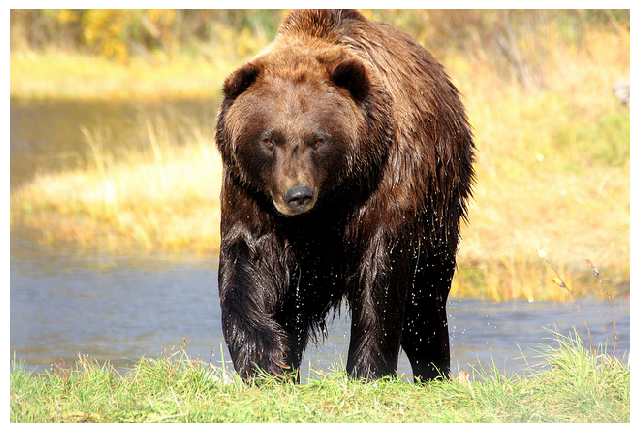

tensor([[[[ 7.1892e-01, -6.2241e-01, -8.7690e-02,  ...,  1.5645e-01,
            1.6710e-01, -2.5238e-01],
          [-1.6190e-01, -5.6082e-01,  2.5136e-01,  ...,  1.1542e-01,
           -1.1773e-01,  8.7774e-02],
          [ 2.8278e-01, -7.0623e-01, -2.0055e-03,  ...,  2.4115e-01,
            4.8419e-01, -1.8448e-01],
          ...,
          [-2.0871e-01, -5.4542e-01,  4.9558e-01,  ...,  2.5434e-01,
           -2.0143e-01, -4.2109e-01],
          [ 1.0745e+00, -1.7862e-01, -1.7492e-01,  ...,  1.8184e-01,
            1.9600e-01, -1.7164e-01],
          [-5.0488e-01, -3.8501e-02, -3.9786e-01,  ..., -3.8219e-01,
           -6.1897e-01, -4.9589e-01]],

         [[-4.4324e-01, -5.7477e-01, -9.2756e-01,  ..., -1.1545e+00,
           -8.7130e-01,  8.1006e-03],
          [ 1.5565e-01, -5.9764e-02,  2.7941e-01,  ...,  5.1400e-01,
            2.4509e-01,  8.0166e-01],
          [-1.0431e-01, -3.5577e-01,  7.7885e-01,  ..., -4.4267e-01,
            2.5734e-01,  7.7493e-01],
          ...,
     

In [23]:
model_theta.zero_grad()
model_xi.zero_grad()

demo_tensor = next(iter(train_data_loader))[0].to(device)
draw_image(np.transpose(demo_tensor.cpu().squeeze(), (1,2,0)))

view_gen = ViewGenerator(demo_tensor)
v0, v1, v2 = view_gen(demo_tensor)
h0, z0 = model_tau(v0)
print(h0)

E: 0 = tensor([3.2624], device='cuda:0', grad_fn=<DivBackward0>)
E: 0 = tensor([1.2079], device='cuda:0', grad_fn=<DivBackward0>)


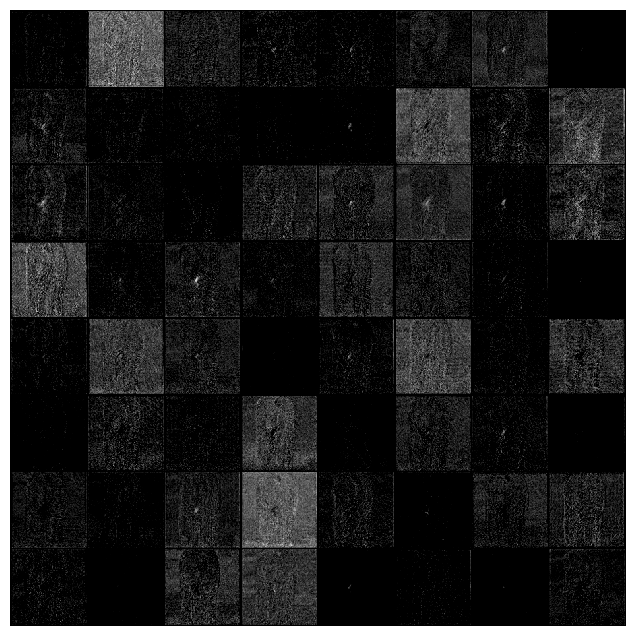

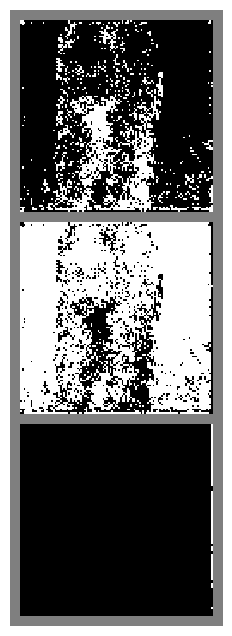

E: 1 = tensor([5.4116], device='cuda:0', grad_fn=<DivBackward0>)
E: 2 = tensor([2.4061], device='cuda:0', grad_fn=<DivBackward0>)
E: 3 = tensor([10.8632], device='cuda:0', grad_fn=<DivBackward0>)
E: 4 = tensor([10.8046], device='cuda:0', grad_fn=<DivBackward0>)
E: 5 = tensor([5.9196], device='cuda:0', grad_fn=<DivBackward0>)
E: 6 = tensor([6.7640], device='cuda:0', grad_fn=<DivBackward0>)
E: 7 = tensor([9.4722], device='cuda:0', grad_fn=<DivBackward0>)
E: 8 = tensor([2424.4116], device='cuda:0', grad_fn=<DivBackward0>)
E: 9 = tensor([4.8129], device='cuda:0', grad_fn=<DivBackward0>)
E: 10 = tensor([2424.4119], device='cuda:0', grad_fn=<DivBackward0>)
E: 11 = tensor([4.8135], device='cuda:0', grad_fn=<DivBackward0>)
E: 12 = tensor([2424.4119], device='cuda:0', grad_fn=<DivBackward0>)
E: 13 = tensor([3.6085], device='cuda:0', grad_fn=<DivBackward0>)
E: 14 = tensor([6.7648], device='cuda:0', grad_fn=<DivBackward0>)
E: 15 = tensor([9.4704], device='cuda:0', grad_fn=<DivBackward0>)
E: 16 = 

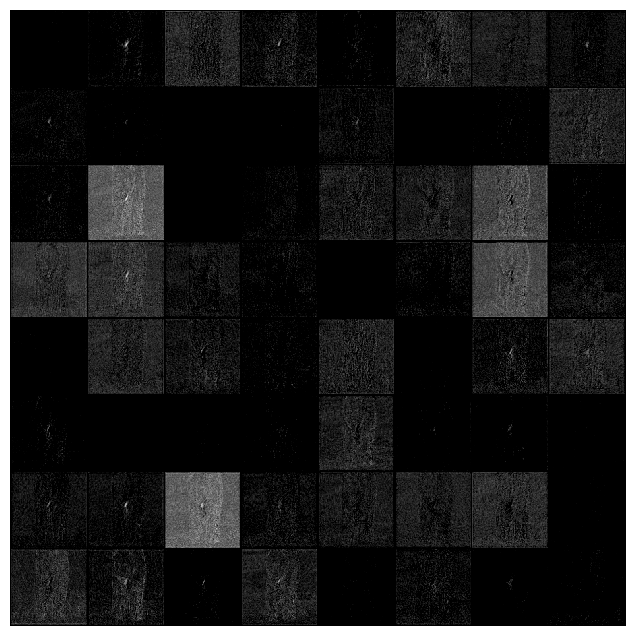

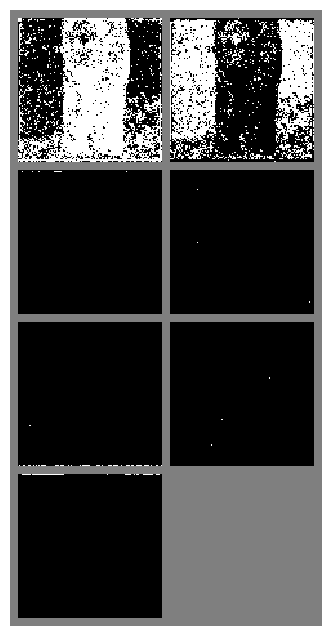

E: 26 = tensor([2424.4119], device='cuda:0', grad_fn=<DivBackward0>)
E: 27 = tensor([5.3866], device='cuda:0', grad_fn=<DivBackward0>)
E: 28 = tensor([2424.4119], device='cuda:0', grad_fn=<DivBackward0>)
E: 29 = tensor([9.7410], device='cuda:0', grad_fn=<DivBackward0>)
E: 30 = tensor([4.0553], device='cuda:0', grad_fn=<DivBackward0>)
E: 31 = tensor([5.6986], device='cuda:0', grad_fn=<DivBackward0>)
E: 32 = tensor([6.8819], device='cuda:0', grad_fn=<DivBackward0>)
E: 33 = tensor([1.2733], device='cuda:0', grad_fn=<DivBackward0>)
E: 34 = tensor([4.7351], device='cuda:0', grad_fn=<DivBackward0>)
E: 35 = tensor([2424.4119], device='cuda:0', grad_fn=<DivBackward0>)
E: 36 = tensor([7.2317], device='cuda:0', grad_fn=<DivBackward0>)
E: 37 = tensor([2424.4116], device='cuda:0', grad_fn=<DivBackward0>)
E: 38 = tensor([10.8233], device='cuda:0', grad_fn=<DivBackward0>)
E: 39 = tensor([5.4256], device='cuda:0', grad_fn=<DivBackward0>)
E: 40 = tensor([10.8232], device='cuda:0', grad_fn=<DivBackward

ValueError: Input X contains NaN.
OPTICS does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [24]:
for i, input_raw in enumerate(train_data_loader):
    model_theta.zero_grad()
    model_xi.zero_grad()
    input_tensor = input_raw[0].to(device)
    
    view_gen = ViewGenerator(input_tensor)
    v0, v1, v2 = view_gen(input_tensor)
    h0, z0 = model_tau(v0)
    
    dists = torch.cdist(z0, z0, p=2)
    dist_mean = dists.mean().item()
    dist_std_dev = dists.std().item()
    dist_median = dists.median().item()
    clusterer = OPTICS(cluster_method="dbscan", eps=dist_median*0.25, n_jobs=4)
    
    num_masks, m0, m1, m2 = generate_masks(z0, clusterer)

    h_1_theta = tfunc.resize(model_theta.f(v1), (224,224), tf.InterpolationMode.BILINEAR)
    h_2_theta = tfunc.resize(model_theta.f(v2), (224,224), tf.InterpolationMode.BILINEAR)

    h_k_1_thetas = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_theta, 0).sum(dim=[2,3])) for m1_i in m1])
    h_k_2_thetas = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i>0, h_2_theta, 0).sum(dim=[2,3])) for m2_i in m2])

    z_k_1_theta = model_theta.g(h_k_1_thetas)
    z_k_2_theta = model_theta.g(h_k_2_thetas)

    p_k_1_theta = model_theta.q(z_k_1_theta)
    p_k_2_theta = model_theta.q(z_k_2_theta)

    h_1_xi = tfunc.resize(model_xi.f(v1), (224, 224), tf.InterpolationMode.BILINEAR)
    h_2_xi = tfunc.resize(model_xi.f(v2), (224, 224), tf.InterpolationMode.BILINEAR)

    h_k_1_xi = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_xi, 0).sum(dim=[2,3])) for m1_i in m1])
    h_k_2_xi = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i>0, h_2_xi, 0).sum(dim=[2,3])) for m2_i in m2])

    z_k_1_xi = model_xi.g(h_k_1_xi)
    z_k_2_xi = model_xi.g(h_k_2_xi)

    p_k_1_xi = model_xi.q(z_k_1_xi)
    p_k_2_xi = model_xi.q(z_k_2_xi)

    loss = total_contrastive_loss(p_k_1_theta, p_k_2_theta, z_k_1_xi, z_k_2_xi, 0.1, num_masks)
    print(f"E: {i} = {loss}")

    loss.backward()
    f_theta_optimizer.step()
    g_theta_optimizer.step()
    q_theta_optimizer.step()
    with torch.no_grad():
        for p_tau, p_theta, p_xi in zip(model_tau.parameters(), model_theta.parameters(),model_xi.parameters()):
            new_p_xi = (1-lambda_xi)*p_xi + lambda_xi*p_theta
            new_p_tau = (1-lambda_tau)*p_tau + lambda_tau*p_theta

            p_xi.copy_(new_p_xi)
            p_tau.copy_(new_p_tau)

    if i%25 == 0:
        view_gen = ViewGenerator(demo_tensor)
        v0, v1, v2 = view_gen(demo_tensor)
        h0, z0 = model_tau(v0)
        
        dists = torch.cdist(z0, z0, p=2)
        dist_mean = dists.mean().item()
        dist_std_dev = dists.std().item()
        clusterer = OPTICS(cluster_method="dbscan", eps=dist_mean-(0.75*dist_std_dev), n_jobs=4)
    
        num_masks, m0, m1, m2 = generate_masks(z0, clusterer)

        h_1_theta = tfunc.resize(model_theta.f(v1), (224,224), tf.InterpolationMode.BILINEAR)
        h_2_theta = tfunc.resize(model_theta.f(v2), (224,224), tf.InterpolationMode.BILINEAR)

        h_k_1_thetas = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_theta, 0).sum(dim=[2,3])) for m1_i in m1])
        h_k_2_thetas = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i>0, h_2_theta, 0).sum(dim=[2,3])) for m2_i in m2])

        z_k_1_theta = model_theta.g(h_k_1_thetas)
        z_k_2_theta = model_theta.g(h_k_2_thetas)

        p_k_1_theta = model_theta.q(z_k_1_theta)
        p_k_2_theta = model_theta.q(z_k_2_theta)

        h_1_xi = tfunc.resize(model_xi.f(v1), (224, 224), tf.InterpolationMode.BILINEAR)
        h_2_xi = tfunc.resize(model_xi.f(v2), (224, 224), tf.InterpolationMode.BILINEAR)

        h_k_1_xi = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_xi, 0).sum(dim=[2,3])) for m1_i in m1])
        h_k_2_xi = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i>0, h_2_xi, 0).sum(dim=[2,3])) for m2_i in m2])

        z_k_1_xi = model_xi.g(h_k_1_xi)
        z_k_2_xi = model_xi.g(h_k_2_xi)

        p_k_1_xi = model_xi.q(z_k_1_xi)
        p_k_2_xi = model_xi.q(z_k_2_xi)

        loss = total_contrastive_loss(p_k_1_theta, p_k_2_theta, z_k_1_xi, z_k_2_xi, 0.1, num_masks)
        print(f"E: {i} = {loss}")
    
        z0_np = z0.detach().cpu().numpy().squeeze()
        draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in z0_np[:64]], padding=2, normalize=True).cpu(), (1,2,0)))

#         h_1_theta_np = h_1_theta.detach().cpu().numpy().squeeze()
#         draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in h_1_theta_np[:64]], padding=2, normalize=True).cpu(), (1,2,0)))

        m0_np = m0.detach().cpu().numpy().squeeze()
#         print(m0_np.shape)
        draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in m0_np], nrow=int(num_masks**0.5), padding=6, pad_value=0.5, normalize=True).cpu(), (1,2,0)))

In [50]:
torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_xi, 0).sum(dim=[2,3])) for m1_i in m1])

tensor([[-0.0463,  0.3997, -1.0890,  0.6273,  0.7882,  0.4536, -0.3308,  0.0105,
          0.4108,  0.8705,  0.0428, -0.3560,  0.4021,  0.1910, -0.2012, -0.9982,
          0.0391,  0.2512,  0.5831,  0.0730,  0.1927, -0.8245,  0.4642,  0.7993,
         -0.6065, -0.2383,  0.3372,  0.5458,  0.0128, -0.0248, -0.4333, -0.4794,
          0.0355, -0.4020, -0.3451, -0.3625,  0.2010,  0.7550,  0.2951,  0.7956,
         -0.2938,  0.4512,  0.8023,  0.0952, -0.2074, -1.2173, -0.2948,  0.4097,
         -0.6217, -0.3936, -0.2943, -0.0264, -0.1464,  0.6324,  0.5557, -0.2243,
          0.2640,  0.1157,  0.1896,  0.0635, -0.0388,  0.4685, -0.2425, -0.1654],
        [-0.1554,  0.3694, -1.0170,  0.3777,  0.9062,  0.4011, -0.6031,  0.0057,
          0.5568,  0.8429, -0.1764, -0.2803,  0.4691,  0.2622, -0.1420, -1.0975,
          0.0935,  0.1814,  0.3759,  0.1773,  0.2937, -0.9626,  0.5197,  0.8195,
         -0.7199, -0.3949,  0.7320,  0.5527,  0.0136,  0.1169, -0.5151, -0.3588,
          0.0413, -0.4678, 

In [ ]:
view_gen = ViewGenerator(demo_tensor)
v0, v1, v2 = view_gen(demo_tensor)

h0, z0 = model_tau(v0)
dists = torch.cdist(z0, z0, p=2)
dist_mean = dists.mean().item()
dist_std_dev = dists.std().item()
dist_median = dists.median().item()
clusterer = OPTICS(cluster_method="dbscan", eps=dist_median*0.25, n_jobs=4)
num_masks, m0, m1, m2 = generate_masks(z0, clusterer)

h_1_theta = tfunc.resize(model_theta.f(v1), (224,224), tf.InterpolationMode.BILINEAR)
h_2_theta = tfunc.resize(model_theta.f(v2), (224,224), tf.InterpolationMode.BILINEAR)

h_k_1_thetas = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i==1, h_1_theta, 0).sum(dim=[2,3])) for m1_i in m1])
h_k_2_thetas = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i==1, h_2_theta, 0).sum(dim=[2,3])) for m2_i in m2])

z_k_1_theta = model_theta.g(h_k_1_thetas)
z_k_2_theta = model_theta.g(h_k_2_thetas)

p_k_1_theta = model_theta.q(z_k_1_theta)
p_k_2_theta = model_theta.q(z_k_2_theta)

h_1_xi = tfunc.resize(model_xi.f(v1), (224, 224), tf.InterpolationMode.BILINEAR)
h_2_xi = tfunc.resize(model_xi.f(v2), (224, 224), tf.InterpolationMode.BILINEAR)

h_k_1_xi = torch.concat([(1/(m1_i.sum()))*(torch.where(m1_i==1, h_1_xi, 0).sum(dim=[2,3])) for m1_i in m1])
h_k_2_xi = torch.concat([(1/(m2_i.sum()))*(torch.where(m2_i==1, h_2_xi, 0).sum(dim=[2,3])) for m2_i in m2])

z_k_1_xi = model_xi.g(h_k_1_xi)
z_k_2_xi = model_xi.g(h_k_2_xi)

p_k_1_xi = model_xi.q(z_k_1_xi)
p_k_2_xi = model_xi.q(z_k_2_xi)

loss = total_contrastive_loss(p_k_1_theta, p_k_2_theta, z_k_1_xi, z_k_2_xi, 0.1, num_masks)
print(f"{loss}")

z0_np = z0.detach().cpu().numpy().squeeze()
draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in z0_np[:64]], padding=2, normalize=True).cpu(), (1,2,0)))

m0_np = m0.detach().cpu().numpy().squeeze()
print(m0_np.shape)
if num_masks > 1:
    draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in m0_np], nrow=int(num_masks**0.5), padding=6, pad_value=0.5, normalize=True).cpu(), (1,2,0)))
else:
    draw_image(m0_np)

In [ ]:
print(dist_mean)
print(dist_std_dev)
print(dists.median().item())

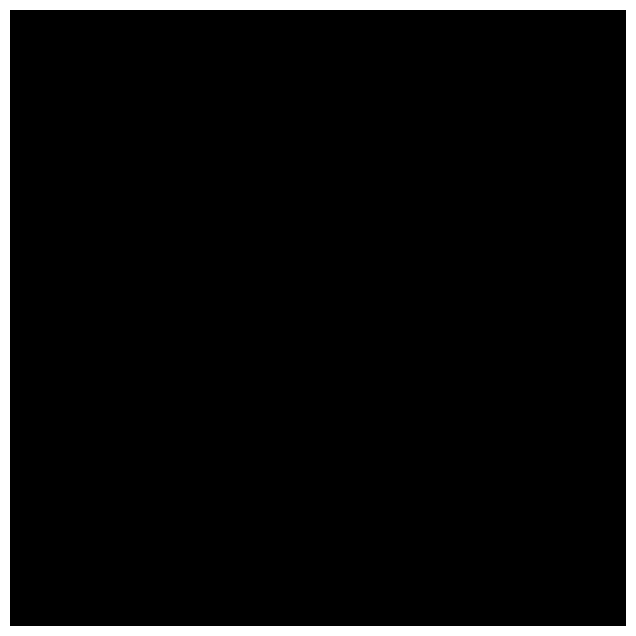

In [25]:
z0_np = z0.detach().cpu().numpy().squeeze()
draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in z0_np[:64]], padding=2, normalize=True).cpu(), (1,2,0)))

In [ ]:
clusterer = OPTICS(cluster_method="dbscan", eps=dists.median().item(), n_jobs=4)
num_masks, m0, m1, m2 = generate_masks(z0, clusterer)

m0_np = m0.detach().cpu().numpy().squeeze()

print(num_masks)
print(m0_np.shape)
if num_masks > 1:
    draw_image(np.transpose(vutils.make_grid([tfunc.to_tensor(j) for j in m0_np], nrow=int(num_masks**0.5), padding=2, pad_value=0.5, normalize=True).cpu(), (1,2,0)))
else:
    draw_image(m0_np)

In [26]:
plt.hist(dists.detach().cpu().histogram())

RuntimeError: torch.histogramdd: dimension 0's range [nan, nan] is not finite

In [ ]:
for m1_i in m1:
    print((1/(m1_i.sum()))*(torch.where(m1_i>0, h_1_theta, 0).sum(dim=[2,3])))

In [ ]:
(1/(m1[2].sum()))*(torch.where(m1[2]>0.5, h_1_theta, 0).sum(dim=[2,3]))

In [ ]:
1/(m1[2].sum())

In [ ]:
m1.shape